**ROTTEN TOMATOES REVIEWS**

El problema consiste en realizar la clasificación de reseñas de películas o series de televisión como "fresh" (fresco) o "rotten" (podrido) basándose en el contenido de las reseñas. El objetivo es utilizar modelos de aprendizaje automático junto a técnicas de procesamiento de lenguaje natural (CountVectorizer - TfidfVectorizer) para predecir la clasificación de nuevas reseñas como "Fresh" o "Rotten".


**CONJUNTO DE DATOS**


El conjunto de datos utilizado se obtuvo del siguiente enlace: https://www.kaggle.com/datasets/ulrikthygepedersen/rotten-tomatoes-reviews. 
Este dataset contiene 480.000 reseñas (240.000 Fresh - 240.000 Rotten) recopiladas del sitio web Rotten Tomatoes. Cada reseña está etiquetada como "fresh" o "rotten" según la clasificación dada por los críticos de cine.

Importamos todas las librerías necesarias para el modelo.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import  confusion_matrix, classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from nltk.stem import PorterStemmer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from wordcloud import WordCloud

Descargamos los paquetes de nltk junto a las stopwords e inicializamos una variable de tipo PorterStemmer para poder llevar las palabras a su forma básica.

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
stemmer = PorterStemmer()
stop_words = stopwords.words('english')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\maiko\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maiko\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Leemos el dataset con la función de Pandas llamada read_csv y mostramos una breve info y descripción de ese conjunto de datos.

In [3]:
file_path = 'rt_reviews.csv'
df = pd.read_csv(file_path, encoding='latin-1')

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480000 entries, 0 to 479999
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Freshness  480000 non-null  object
 1   Review     480000 non-null  object
dtypes: object(2)
memory usage: 7.3+ MB


,Freshness,Review
0,fresh,"Manakamana doesn't answer any questions, yet ..."
1,fresh,Wilfully offensive and powered by a chest-thu...
2,rotten,It would be difficult to imagine material mor...
3,rotten,Despite the gusto its star brings to the role...
4,rotten,If there was a good idea at the core of this ...


Utilizamos seaborn para gráficar este conjunto de datos y validar si está balanceado.

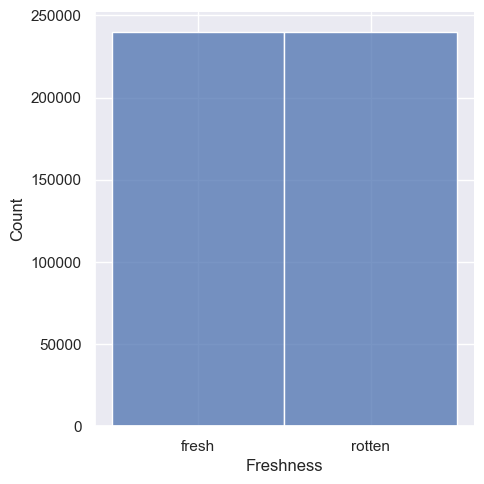

In [4]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.displot(df['Freshness'], bins=30)
plt.show()

**PREPROCESAMIENTO DE DATOS**



*   Tokenizamos las reviews.
*   Eliminamos los signos de puntuación.
*   Convertimos todas las palabras en minúsculas.
*   Aplicamos Stemmer para llevar las palabras a su forma básica.
*   Eliminamos esas palabras que vienen en el conjunto antes descargado (StopWords)



In [5]:
def preprocess(txt):
    txt = txt.lower()
    txt = ' '.join([word for word in txt.split() if word not in string.punctuation])
    txt = ' '.join([word for word in txt.split() if word not in stop_words])
    return txt

df['Review'] = df['Review'].apply(lambda x: ' '.join(word_tokenize(x)))
df['ReviewClean'] = df['Review'].apply(lambda x: preprocess(x))
df.head()

,Freshness,Review,ReviewClean
0,fresh,"Manakamana does n't answer any questions , yet...",manakamana n't answer questions yet makes poin...
1,fresh,Wilfully offensive and powered by a chest-thum...,wilfully offensive powered chest-thumping mach...
2,rotten,It would be difficult to imagine material more...,would difficult imagine material wrong spade l...
3,rotten,Despite the gusto its star brings to the role ...,despite gusto star brings role 's hard ride sh...
4,rotten,If there was a good idea at the core of this f...,good idea core film 's buried unsightly pile f...


Creamos dos nuevos DataFrames, uno para las reviews en Fresh y otro para las reviews en Rotten. Luego, utilizando CountVectorizer obtenemos una matriz de frencuencia para las características que están en estos dataframes. Por último, mostramos un WordCloud con las 300 palabras más frecuentes para ambos valores.

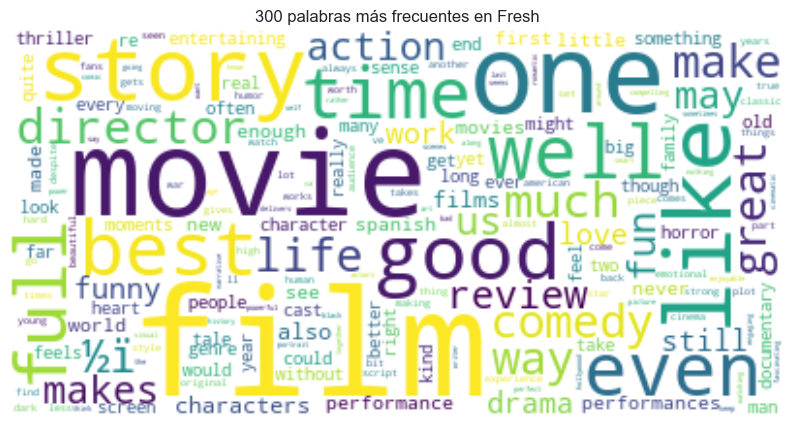

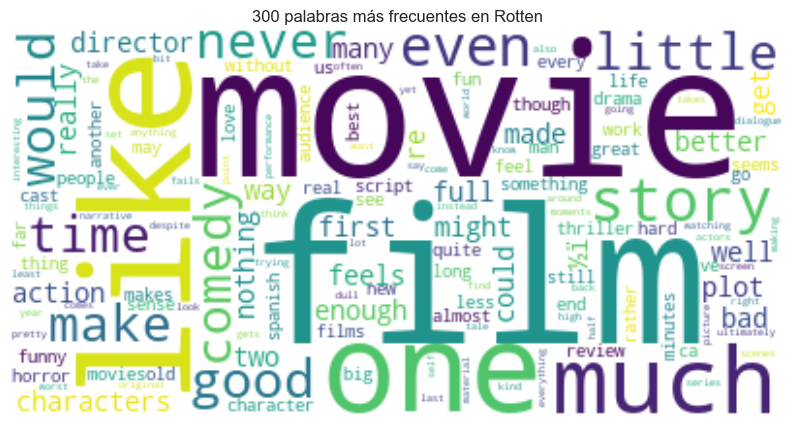

In [6]:
df_fresh = df.loc[df['Freshness'] == 'fresh']
df_rotten = df.loc[df['Freshness'] == 'rotten']

count_vectorizer_fresh = CountVectorizer()
count_vectorizer_rotten = CountVectorizer()

count_matrix_fresh = count_vectorizer_fresh.fit_transform(df_fresh['ReviewClean'])
count_matrix_rotten = count_vectorizer_rotten.fit_transform(df_rotten['ReviewClean'])

vocabulary_fresh = count_vectorizer_fresh.get_feature_names_out()
vocabulary_rotten = count_vectorizer_rotten.get_feature_names_out()

term_frequencies_fresh = count_matrix_fresh.sum(axis=0).A1
term_frequencies_rotten = count_matrix_rotten.sum(axis=0).A1

top_indices_fresh = term_frequencies_fresh.argsort()[-300:][::-1]
top_indices_rotten = term_frequencies_rotten.argsort()[-300:][::-1]

top_count_terms_fresh = [vocabulary_fresh[i] for i in top_indices_fresh]
top_count_terms_rotten = [vocabulary_rotten[i] for i in top_indices_rotten]

wordcloud_data_count = {term: freq for term, freq in zip(top_count_terms_fresh, term_frequencies_fresh[top_indices_fresh])}
wordcloud_count = WordCloud(background_color='white').generate_from_frequencies(wordcloud_data_count)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud_count, interpolation='bilinear')
plt.axis('off')
plt.title('300 palabras más frecuentes en Fresh')
plt.show()

wordcloud_data_count = {term: freq for term, freq in zip(top_count_terms_rotten, term_frequencies_rotten[top_indices_rotten])}
wordcloud_count = WordCloud(background_color='white').generate_from_frequencies(wordcloud_data_count)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud_count, interpolation='bilinear')
plt.axis('off')
plt.title('300 palabras más frecuentes en Rotten')
plt.show()


Aplicamos Stem para llevar las características a su forma básica.

In [7]:
df['Stemmed_Reviews'] = df['ReviewClean'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))
df.head()

,Freshness,Review,ReviewClean,Stemmed_Reviews
0,fresh,"Manakamana does n't answer any questions , yet...",manakamana n't answer questions yet makes poin...,manakamana n't answer question yet make point ...
1,fresh,Wilfully offensive and powered by a chest-thum...,wilfully offensive powered chest-thumping mach...,wil offens power chest-thump machismo 's good ...
2,rotten,It would be difficult to imagine material more...,would difficult imagine material wrong spade l...,would difficult imagin materi wrong spade lost...
3,rotten,Despite the gusto its star brings to the role ...,despite gusto star brings role 's hard ride sh...,despit gusto star bring role 's hard ride shot...
4,rotten,If there was a good idea at the core of this f...,good idea core film 's buried unsightly pile f...,good idea core film 's buri unsightli pile fla...


Escalamos la columna Freshness que contiene "Fresh" - "Rotten" a 0 - 1 para poder trabajar con ellos en modelos de aprendizaje automático. 

In [8]:
df['Freshness'] = df['Freshness'].apply(lambda x: 1 if x=='rotten' else 0)
df.head()

,Freshness,Review,ReviewClean,Stemmed_Reviews
0,0,"Manakamana does n't answer any questions , yet...",manakamana n't answer questions yet makes poin...,manakamana n't answer question yet make point ...
1,0,Wilfully offensive and powered by a chest-thum...,wilfully offensive powered chest-thumping mach...,wil offens power chest-thump machismo 's good ...
2,1,It would be difficult to imagine material more...,would difficult imagine material wrong spade l...,would difficult imagin materi wrong spade lost...
3,1,Despite the gusto its star brings to the role ...,despite gusto star brings role 's hard ride sh...,despit gusto star bring role 's hard ride shot...
4,1,If there was a good idea at the core of this f...,good idea core film 's buried unsightly pile f...,good idea core film 's buri unsightli pile fla...


Aplicamos CountVectorizer y TfidfVectorizer al conjunto de datos.

In [9]:
count_vectorizer = CountVectorizer()
count_matrix = count_vectorizer.fit_transform(df['Stemmed_Reviews'])
feature_names_count = count_vectorizer.get_feature_names_out()

tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['Stemmed_Reviews'])
feature_names_tfidf = tfidf_vectorizer.get_feature_names_out()

**DIVISIÓN DE CONJUNTOS**

* 40% de los datos para prueba.
* 60% para entrenamiento.

Esto aplica tanto para los datos transformados por CountVectorizer como los TF-IDF.

In [ ]:
x_train_count, x_test_count, y_train_count, y_test_count = train_test_split(count_matrix, df['Freshness'], test_size=0.4, random_state=42)
x_train_tfidf, x_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(tfidf_matrix, df['Freshness'], test_size=0.4, random_state=42)

Ahora, utilizamos RandomForest junto a SelectFromModel para hacer una selección de carácteristicas, se tomarán aquellas que estén por encima de la media (treshfold='mean'), esto para reducir la dimensionalidad y mejorar la precisión y eficiencia de los modelos. Luego, esas características seleccionadas, son las que se usarán para hacer la predicción en distintos modelos.

In [10]:
rf_count = RandomForestClassifier(random_state=42)
rf_tfidf = RandomForestClassifier(random_state=42)
rf_count.fit(x_train_count, y_train_count)
rf_tfidf.fit(x_train_tfidf, y_train_tfidf)

importances_count = rf_count.feature_importances_
importances_tfidf = rf_tfidf.feature_importances_

selector_count = SelectFromModel(rf_count, threshold='mean')
selector_tfidf = SelectFromModel(rf_tfidf, threshold='mean')

x_train_count_selected = selector_count.transform(x_train_count)
x_test_count_selected = selector_count.transform(x_test_count)
x_train_tfidf_selected = selector_tfidf.transform(x_train_tfidf)
x_test_tfidf_selected = selector_tfidf.transform(x_test_tfidf)

selected_indices_count = selector_count.get_support(indices=True)
selected_indices_tfidf = selector_tfidf.get_support(indices=True)

#Variables que se usaran para entrenar el modelo.
x_train_count_selected = x_train_count[:, selected_indices_count]
x_test_count_selected = x_test_count[:, selected_indices_count]
x_train_tfidf_selected = x_train_tfidf[:, selected_indices_tfidf]
x_test_tfidf_selected = x_test_tfidf[:, selected_indices_tfidf]

feature_names_count_selected = [feature_names_count[idx] for idx in selected_indices_count]
feature_names_tfidf_selected = [feature_names_tfidf[idx] for idx in selected_indices_tfidf]

Graficamos el número de características originales vs las seleccionadas por RandomForest para entrenar el modelo.

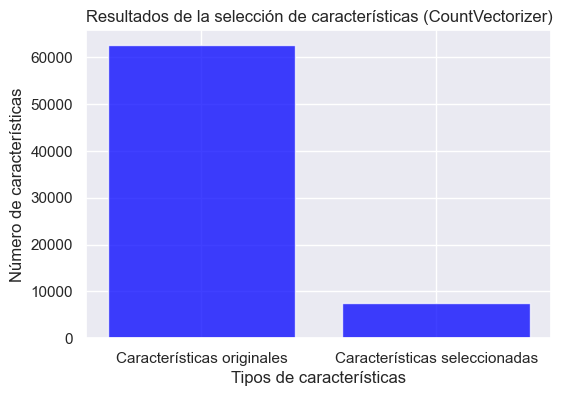

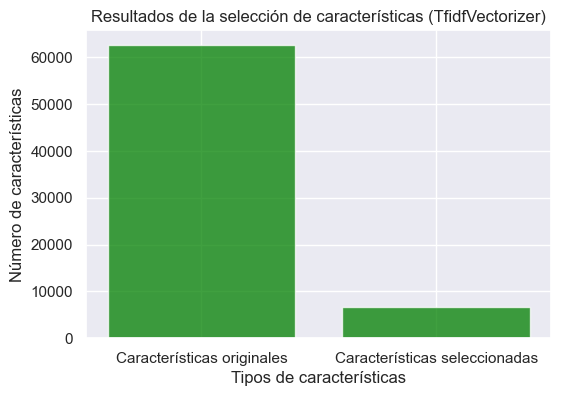

In [11]:
num_features_original_count = x_train_count.shape[1]
num_features_selected_count = x_train_count_selected.shape[1]

labels_count = ['Características originales', 'Características seleccionadas']
values_count = [num_features_original_count, num_features_selected_count]

plt.figure(figsize=(6,4))
plt.bar(labels_count, values_count, color='blue', alpha=0.75)
plt.title('Resultados de la selección de características (CountVectorizer)')
plt.xlabel('Tipos de características')
plt.ylabel('Número de características')
plt.show()
print("\n")

num_features_original_tfidf = x_train_tfidf.shape[1]
num_features_selected_tfidf = x_train_tfidf_selected.shape[1]

labels_tfidf = ['Características originales', 'Características seleccionadas']
values_tfidf = [num_features_original_tfidf, num_features_selected_tfidf]

plt.figure(figsize=(6, 4))
plt.bar(labels_tfidf, values_tfidf, color='green', alpha=0.75)
plt.title('Resultados de la selección de características (TfidfVectorizer)')
plt.xlabel('Tipos de características')
plt.ylabel('Número de características')
plt.show()

**MODELOS DE APRENDIZAJE UTILIZADOS.**


*   Árboles de decisión.
*   Random Forest.
*   Redes Neuronales.
*   Redes Neuronales Profundas.

Se aplicó tanto para el conjunto de datos transformados por CountVectorizer como para TF-IDF. Además, se utilizó GridSearchCV para el ajuste de hiperparámetros y una mejor evaluación del modelo.

**OUTPUTS**


*   Tabla de las posibles combinaciónes y sus respectivos MeanScore y StdScore (Desviación) 
*   Reporte de clasificación, el cual evalua el modelo con medidas como Precisión, Recall, F1-Score, Acurracy y cantidad de datos seleccionados.
*   Mejor combinación de parámetros obtenidos.
*   Matriz de Confusión.



DecisionTreeClassifier con TF-IDF.

In [13]:
#Definimos los parámetros a utilizar.
parameters = {
    'criterion' : ['gini','entropy']
}
classifier = DecisionTreeClassifier()

In [ ]:
#Aplicamos al conjunto TF-IDF
grid_searchDTC = GridSearchCV(classifier, parameters, scoring='accuracy', cv=3)
grid_searchDTC.fit(x_train_tfidf_selected, y_train_tfidf)
best_paramsDTC = grid_searchDTC.best_params_
best_modelDTC = grid_searchDTC.best_estimator_
freshness_predDTC = best_modelDTC.predict(x_test_tfidf_selected)

results = []

for params, mean_score, std_score in zip(grid_searchDTC.cv_results_['params'],
                                         grid_searchDTC.cv_results_['mean_test_score'],
                                         grid_searchDTC.cv_results_['std_test_score']):
    criterion = params['criterion']
    
    result = {
        'Criterion' : criterion,
        'MeanS': mean_score,
        'StdS': std_score
    }
    results.append(result)

df_results = pd.DataFrame(results)
print(f'''Tabla de Hiperparámetros: 
{df_results}
\nReporte de Clasificación:
{classification_report(y_test_tfidf, freshness_predDTC)}
\nMejor Combinación de Parámetros: {best_paramsDTC}
\nMatriz de Confusión: 
{confusion_matrix(y_test_tfidf, freshness_predDTC)}''')

Tabla de Hiperparámetros: 
  Criterion     MeanS      StdS
0      gini  0.739837  0.001736
1   entropy  0.740267  0.000212

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.78      0.77      0.77     95935
           1       0.77      0.79      0.78     96065

    accuracy                           0.78    192000
   macro avg       0.78      0.78      0.78    192000
weighted avg       0.78      0.78      0.78    192000


Mejor Combinación de Parámetros: {'criterion': 'entropy'}

Matriz de Confusión: 
[[73546 22389]
 [20487 75578]]


DecisionTreeClassifier con CountVectorizer.

In [14]:
#Aplicamos al conjunto CountVectorizer.
grid_searchDTCC = GridSearchCV(classifier, parameters, scoring='accuracy', cv=3)
grid_searchDTCC.fit(x_train_count_selected, y_train_count)
best_paramsDTCC = grid_searchDTCC.best_params_
best_modelDTCC = grid_searchDTCC.best_estimator_
freshness_predDTCC = best_modelDTCC.predict(x_test_count_selected)

resultsC = []

for params, mean_score, std_score in zip(grid_searchDTCC.cv_results_['params'],
                                         grid_searchDTCC.cv_results_['mean_test_score'],
                                         grid_searchDTCC.cv_results_['std_test_score']):
    criterion = params['criterion']
    resultC = {
        'Criterion' : criterion,
        'MeanS': mean_score,
        'StdS': std_score
    }
    resultsC.append(resultC)

df_resultsC = pd.DataFrame(resultsC)
print(f'''Tabla de Hiperparámetros: 
{df_resultsC}
\nReporte de Clasificación:
{classification_report(y_test_count, freshness_predDTCC)}
\nMejor Combinación de Parámetros: {best_paramsDTCC}
\nMatriz de Confusión: 
{confusion_matrix(y_test_count, freshness_predDTCC)}''')

Tabla de Hiperparámetros: 
  Criterion     MeanS      StdS
0      gini  0.742656  0.001196
1   entropy  0.746240  0.000470

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.79      0.77      0.78     95935
           1       0.78      0.80      0.79     96065

    accuracy                           0.78    192000
   macro avg       0.78      0.78      0.78    192000
weighted avg       0.78      0.78      0.78    192000


Mejor Combinación de Parámetros: {'criterion': 'entropy'}

Matriz de Confusión: 
[[73833 22102]
 [19594 76471]]


RandomForestClassifier

In [12]:
#Definimos los parámetros a utilizar.
model = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [20, 50, 100],
    'criterion': ['gini', 'entropy']
}

RandomForestClassifier con TF-IDF.

In [16]:
#Aplicamos al conjunto TF-IDF
grid_searchRFC = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_searchRFC.fit(x_train_tfidf_selected, y_train_count)
best_paramsRFC = grid_searchRFC.best_params_
best_modelRFC = grid_searchRFC.best_estimator_
freshness_predRFC = best_modelRFC.predict(x_test_tfidf_selected)

resultsR = []

for params, mean_score, std_score in zip(grid_searchRFC.cv_results_['params'],
                                         grid_searchRFC.cv_results_['mean_test_score'],
                                         grid_searchRFC.cv_results_['std_test_score']):
    n_estimators = params['n_estimators']
    criterion = params['criterion']
    
    resultR = {
        'Estimators': n_estimators,
        'Criterion': criterion,
        'MeanS': mean_score,
        'StdS': std_score
    }
    resultsR.append(resultR)

df_resultsR = pd.DataFrame(resultsR)
print(f'''Tabla de Hiperparámetros: 
{df_resultsR}
\nReporte de Clasificación:
{classification_report(y_test_count, freshness_predRFC)}
\nMejor Combinación de Parámetros: {best_paramsRFC}
\nMatriz de Confusión: 
{confusion_matrix(y_test_count, freshness_predRFC)}''')

Tabla de Hiperparámetros: 
   Estimators Criterion     MeanS      StdS
0          20      gini  0.791972  0.000227
1          50      gini  0.798337  0.000293
2         100      gini  0.800750  0.000620
3          20   entropy  0.793125  0.000335
4          50   entropy  0.800757  0.000299
5         100   entropy  0.802722  0.000411

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83     95935
           1       0.83      0.83      0.83     96065

    accuracy                           0.83    192000
   macro avg       0.83      0.83      0.83    192000
weighted avg       0.83      0.83      0.83    192000


Mejor Combinación de Parámetros: {'criterion': 'entropy', 'n_estimators': 100}

Matriz de Confusión: 
[[79851 16084]
 [16360 79705]]


RandomForestClassifier con CountVectorizer.

In [13]:
#Aplicamos al conjunto CountVectorizer.
grid_searchRFCC = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_searchRFCC.fit(x_train_count_selected, y_train_count)
best_paramsRFCC = grid_searchRFCC.best_params_
best_modelRFCC = grid_searchRFCC.best_estimator_
freshness_predRFCC = best_modelRFCC.predict(x_test_count_selected)

resultsRC = []

for params, mean_score, std_score in zip(grid_searchRFCC.cv_results_['params'],
                                         grid_searchRFCC.cv_results_['mean_test_score'],
                                         grid_searchRFCC.cv_results_['std_test_score']):
    n_estimators = params['n_estimators']
    criterion = params['criterion']
    
    resultRC = {
        'Estimators': n_estimators,
        'Criterion' : criterion,
        'MeanS': mean_score,
        'StdS': std_score
    }
    resultsRC.append(resultRC)

df_resultsRC = pd.DataFrame(resultsRC)
print(f'''Tabla de Hiperparámetros: 
{df_resultsRC}
\nReporte de Clasificación:
{classification_report(y_test_count, freshness_predRFCC)}
\nMejor Combinación de Parámetros: {best_paramsRFCC}
\nMatriz de Confusión: 
{confusion_matrix(y_test_count,freshness_predRFCC)}''')

Tabla de Hiperparámetros: 
   Estimators Criterion     MeanS      StdS
0          20      gini  0.791587  0.000642
1          50      gini  0.799094  0.000433
2         100      gini  0.801146  0.000438
3          20   entropy  0.795354  0.000486
4          50   entropy  0.801944  0.000430
5         100   entropy  0.803927  0.000737

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83     95935
           1       0.83      0.83      0.83     96065

    accuracy                           0.83    192000
   macro avg       0.83      0.83      0.83    192000
weighted avg       0.83      0.83      0.83    192000


Mejor Combinación de Parámetros: {'criterion': 'entropy', 'n_estimators': 100}

Matriz de Confusión: 
[[79668 16267]
 [15899 80166]]


Redes Neuronales de 1 Capa con TF-IDF

In [14]:
#Instanceamos los distintos parámetros a utilizar.
parameters1C = {
    'hidden_layer_sizes' : [(100,), (120,),(150,)],  
    'max_iter' : [400, 500]     
}
clf = MLPClassifier(activation='relu', random_state=42, solver='adam')

In [15]:
#Aplicamos al conjunto TF-IDF
grid_searchML1C = GridSearchCV(clf, parameters1C, scoring='accuracy', cv=3)
grid_searchML1C.fit(x_train_tfidf_selected, y_train_tfidf)
best_paramsML1C = grid_searchML1C.best_params_
best_modelML1C = grid_searchML1C.best_estimator_
freshness_predML1C = best_modelML1C.predict(x_test_tfidf_selected)

resultsML1C = []

for params in grid_searchML1C.cv_results_['params']:
    capas = params['hidden_layer_sizes']
    max_iter = params['max_iter']
    
    resultML1C = {
        'Capas' : capas,
        'MaxIter' : max_iter
    }
    resultsML1C.append(resultML1C)

df_resultsML1C = pd.DataFrame(resultsML1C)
print(f'''Tabla de Hiperparámetros: 
{df_resultsML1C}
\nReporte de Clasificación:
{classification_report(y_test_tfidf, freshness_predML1C)}
\nMejor Combinación de Parámetros: {best_paramsML1C}
\nMatriz de Confusión: 
{confusion_matrix(y_test_tfidf,freshness_predML1C)}''')

Tabla de Hiperparámetros: 
    Capas  MaxIter
0  (100,)      400
1  (100,)      500
2  (120,)      400
3  (120,)      500
4  (150,)      400
5  (150,)      500

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.85      0.84      0.84     95935
           1       0.84      0.85      0.85     96065

    accuracy                           0.84    192000
   macro avg       0.84      0.84      0.84    192000
weighted avg       0.84      0.84      0.84    192000


Mejor Combinación de Parámetros: {'hidden_layer_sizes': (150,), 'max_iter': 400}

Matriz de Confusión: 
[[80323 15612]
 [14333 81732]]


Redes Neuronales de 1 Capa con CountVectorizer.

In [17]:
#Aplicamos al conjunto CountVectorizer
grid_searchML1CC = GridSearchCV(clf, parameters1C, scoring='accuracy', cv=3)
grid_searchML1CC.fit(x_train_count_selected, y_train_count)
best_paramsML1CC = grid_searchML1CC.best_params_
best_modelML1CC = grid_searchML1CC.best_estimator_
freshness_predML1CC = best_modelML1CC.predict(x_test_count_selected)

resultsML1CC = []

for params in grid_searchML1CC.cv_results_['params']:
    capas = params['hidden_layer_sizes']
    max_iter = params['max_iter']
    
    resultML1CC = {
        'Capas' : capas,
        'MaxIter' : max_iter
    }
    resultsML1CC.append(resultML1CC)

df_resultsML1CC = pd.DataFrame(resultsML1CC)
print(f'''Tabla de Hiperparámetros: 
{df_resultsML1CC}
\nReporte de Clasificación:
{classification_report(y_test_count, freshness_predML1CC)}
\nMejor Combinación de Parámetros: {best_paramsML1CC}
\nMatriz de Confusión: 
{confusion_matrix(y_test_count,freshness_predML1CC)}''')

Tabla de Hiperparámetros: 
    Capas  MaxIter
0  (100,)      400
1  (100,)      500
2  (120,)      400
3  (120,)      500
4  (150,)      400
5  (150,)      500

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.85      0.83      0.84     95935
           1       0.84      0.85      0.84     96065

    accuracy                           0.84    192000
   macro avg       0.84      0.84      0.84    192000
weighted avg       0.84      0.84      0.84    192000


Mejor Combinación de Parámetros: {'hidden_layer_sizes': (150,), 'max_iter': 400}

Matriz de Confusión: 
[[80095 15840]
 [14628 81437]]


Redes Neuronales de 3 capas con TF-IDF.

In [18]:
#Definimos los parámetros a utilizar.
parameters = {
    'hidden_layer_sizes' : [(100,100,100), (120,120,120)],  
    'max_iter' : [500, 600]     
}

In [17]:
#Aplicamos al conjunto TF-IDF
grid_searchML = GridSearchCV(clf, parameters, scoring='accuracy', cv=3)
grid_searchML.fit(x_train_tfidf_selected, y_train_tfidf)
best_paramsML = grid_searchML.best_params_
best_modelML = grid_searchML.best_estimator_
freshness_predML = best_modelML.predict(x_test_tfidf_selected)

resultsML = []

for params in grid_searchML.cv_results_['params']:
    capas = params['hidden_layer_sizes']
    max_iter = params['max_iter']
    
    resultML = {
        'Capas' : capas,
        'MaxIter' : max_iter
    }
    resultsML.append(resultML)

df_resultsML = pd.DataFrame(resultsML)
print(f'''Tabla de Hiperparámetros: 
{df_resultsML}
\nReporte de Clasificación:
{classification_report(y_test_tfidf, freshness_predML)}
\nMejor Combinación de Parámetros: {best_paramsML}
\nMatriz de Confusión: 
{confusion_matrix(y_test_tfidf,freshness_predML)}''')

Tabla de Hiperparámetros: 
             Capas  MaxIter
0  (100, 100, 100)      500
1  (100, 100, 100)      600
2  (120, 120, 120)      500
3  (120, 120, 120)      600

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.83      0.81      0.82     95935
           1       0.82      0.83      0.82     96065

    accuracy                           0.82    192000
   macro avg       0.82      0.82      0.82    192000
weighted avg       0.82      0.82      0.82    192000


Mejor Combinación de Parámetros: {'hidden_layer_sizes': (120, 120, 120), 'max_iter': 500}

Matriz de Confusión: 
[[77835 18100]
 [15923 80142]]


Redes Neuronales de 3 capas con CountVectorizer.

In [19]:
#Aplicamos al conjunto CountVectorizer
grid_searchMLC = GridSearchCV(clf, parameters, scoring='accuracy', cv=3)
grid_searchMLC.fit(x_train_count_selected, y_train_count)
best_paramsMLC = grid_searchMLC.best_params_
best_modelMLC = grid_searchMLC.best_estimator_
freshness_predMLC = best_modelMLC.predict(x_test_count_selected)

resultsMLC = []

for params in grid_searchMLC.cv_results_['params']:
    capas = params['hidden_layer_sizes']
    max_iter = params['max_iter']
    
    resultMLC = {
        'Capas' : capas,
        'MaxIter' : max_iter
    }
    resultsMLC.append(resultMLC)

df_resultsMLC = pd.DataFrame(resultsMLC)
print(f'''Tabla de Hiperparámetros: 
{df_resultsMLC}
\nReporte de Clasificación:
{classification_report(y_test_count, freshness_predMLC)}
\nMejor Combinación de Parámetros: {best_paramsMLC}
\nMatriz de Confusión: 
{confusion_matrix(y_test_count,freshness_predMLC)}''')

Tabla de Hiperparámetros: 
             Capas  MaxIter
0  (100, 100, 100)      500
1  (100, 100, 100)      600
2  (120, 120, 120)      500
3  (120, 120, 120)      600

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.83      0.82      0.83     95935
           1       0.82      0.83      0.83     96065

    accuracy                           0.83    192000
   macro avg       0.83      0.83      0.83    192000
weighted avg       0.83      0.83      0.83    192000


Mejor Combinación de Parámetros: {'hidden_layer_sizes': (120, 120, 120), 'max_iter': 500}

Matriz de Confusión: 
[[78906 17029]
 [15939 80126]]


**TABLA DE RESULTADOS**

<img src="Tabla.png">

<img src="Accuracy.png">

**CONCLUSIONES Y RECOMENDACIONES**

El propósito de este trabajo fue comparar algoritmos con diferentes técnicas de procesamiento de lenguaje natural (CountVectorizer - TfidfVectorizer) utilizando aprendizaje automático. Todos los datos fueron preprocesados y utilizados para la predicción de pruebas. Cada algoritmo aplicó estas técnicas. Random Forest (RF), Artificial Neural Network (MLP) (1C - 3C) son los modelos que funcionaron mejor en el conjunto de datos utilizado en este estudio. Los resultados experimentales muestran que la selección de características junto a estas técnicas de procesamiento aumenta la precisión predictiva de los conjuntos de datos de RottenTomatoes.

Recomendaciones:
*   Incrementar el n_estimators en Random Forest puede arrojar mejores resultados.
*   Aumentar el número de neuronas por capa puede ser mejor que aumentar el numero de capas.

Limitaciones:
*   Hardware para realizar pruebas más exhaustivas.
*   Límite de tiempo disponible.